<a href="https://colab.research.google.com/github/IsakLarsson/AppJavaProjekt/blob/master/Transfer_learning_Isak_%C3%85man_Larsson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Isak Åman Larsson

TensorFlow version: 2.3.0
Keras version: 2.4.0
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


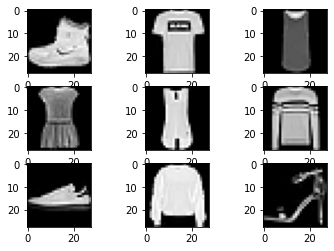

In [ ]:
## Skapad av Isak Åman Larsson isla0031

# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from keras.datasets import fashion_mnist 
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# hämta datat
(train_images0, train_labels0), (test_images, test_labels) = fashion_mnist.load_data()

# summera det hämtade datat
print('Train: X=%s, y=%s' % (train_images0.shape, train_labels0.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

# plotta första bilderna för att se hur de ser ut
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(train_images0[i], cmap=plt.get_cmap('gray'))
plt.show()


In [ ]:
# Splitta i training och validation (20% validation) med random state=2 för reproducerbara resultat
train_images, val_images, train_labels, val_labels = train_test_split(train_images0, train_labels0, test_size=0.20, random_state=2)

# Normalisera bilderna
train_images = (train_images / 255)
test_images = (test_images / 255)
val_images = (val_images / 255) 

## printa antalet train, val och test bilder samt labels för att se att allt ser bra ut
print('Train set: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Validation set: X=%s, y=%s' % (val_images.shape, val_labels.shape))
print('Test set: X=%s, y=%s' % (test_images.shape, test_labels.shape))



Train set: X=(48000, 28, 28), y=(48000,)
Validation set: X=(12000, 28, 28), y=(12000,)
Test set: X=(10000, 28, 28), y=(10000,)


#Skala om bilderna i färg och storlek

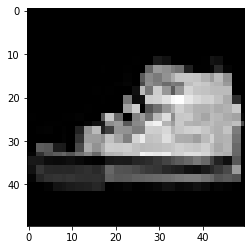

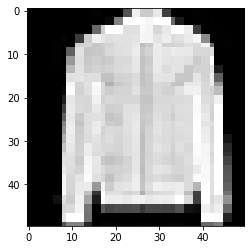

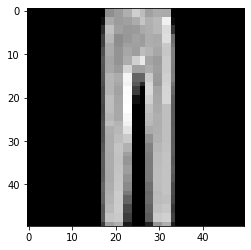

In [ ]:
import cv2

#definiera nya dimensioner
new_width = 50
new_height = 50
dim = (new_width, new_height)


# funktion för att skala om bilderna, inte jätteoptimal då den måste hålla upp till 
# 2x48000 bilder i minnet samtidigt, vilket leder till att RAM minnet tar slut
# om man försöker skala upp bildera högre än 75x75. Men för detta syfte funkar
# det bra. 50x50 fungerar fint
def reshape_set(images):
  reshaped_set = []
  for image in images:
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)
    converted_image = np.float32(resized)
    recolored = cv2.cvtColor(converted_image,cv2.COLOR_GRAY2BGR)
    reshaped_set.append(recolored)

  return np.array(reshaped_set)

#Skala om bild seten
train_images_resized = reshape_set(train_images)
val_images_resized = reshape_set(val_images)
test_images_resized = reshape_set(test_images)


#Plotta godtycklig bild ur varje set för att se att omskalningen gått bra
plt.imshow(train_images_resized[33], cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(val_images_resized[37], cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(test_images_resized[24], cmap=plt.get_cmap('gray'))
plt.show()



In [ ]:
# Printa formen på arrayerna för att se att den har blivit omskalad till (dim,dim, 3)
print("training images shape: ", train_images_resized.shape)
print("validation images shape: ", val_images_resized.shape)
print("test images shape: ", test_images_resized.shape)


training images shape:  (48000, 50, 50, 3)
validation images shape:  (12000, 50, 50, 3)
test images shape:  (10000, 50, 50, 3)


#Importera VGG16 modellen

##Inspektera modellen

In [ ]:
#import the VGG16 model
from keras import applications
from keras.callbacks import EarlyStopping

vgg_model = applications.VGG16(
    weights='imagenet',
    include_top=False,  #annars måste input vara 256x256
    input_shape=(new_height, new_width ,3)   #specificera min input
    )

#Printa summary för att inspektera modellens lager
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Här ser vi att denna modell med sina 19 lager är helt enormt stor jämfört med de som vi skapat under de tidigare labbarna. Testade för skojs skull att inkludera top lagren, alltså de sista lagren som klassifierar 1000 olika klasser från imagenet. Totala antalet trainable parametrar är då 138,357,544, vilket är helt galet. Jag förstår varför det sägs att denna modell tog veckor att träna.

## Bygg på VGG16 modellen med egna lager


NOTERA: Ju mer av modellen man inkluderar, desto större bilder behövs eftersom att bilden skalas ner för varje pooling lager. Bilderna måste vara minst 70x70 för att man ska kunna inkludera den 4e blocket.

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Först lägger vi in vgg16 modellens lager i en dict för att kunna kalla på dem
# via deras namn ex "block3_conv1" för det första conv lagret i det första "blocket"
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Här hämtar vi output tensorn från ett givet lager för att kunna länka ihop
# modellen med min egen påbyggnad
x = layer_dict['block3_pool'].output



# Bygg på med egna lager, i detta fall en modell från en tidigare lab
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(10, activation='softmax')(x)

# Skapa den nya modellen med vgg modellens input som input och mina lager som
# output
new_model = Model(vgg_model.input, x)
new_model.summary()


Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

Här ser vi modellen med mina pålagda lager, men det är någonting som är fel... miljoner trainable parameters. Vi måste alltså se till att de första lagren inte är trainable för att undvika att behöva träna om hela modellen vilket skulle besegra syftet med transfer learning.

## Välj bort vissa lager

In [ ]:
# Gör de tidigare lagren icke träningsbara 11 för block 3 och 15 för block 4
for layer in new_model.layers[:11]:
    layer.trainable = False                                         


new_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

new_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

Mycket bättre, istället för miljoner träningsbara parametrar har vi nu endast ca hundra tusen.

# Träna den nya modellen

UPDATE: Testade även att leka runt lite med data augmentation för att se om resultatet blev bättre, fast utan framgång. Det nådde som högst upp till 91.3%, men jag lämnar koden utkommenterad om du som rättar vill köra den versionen, notera att det får träningen att ta betydligt längre. Min gissning är att test datat inte är nog varierat för att det ska ge någon effekt av att rotera, dra ut eller skala bilderna.

In [ ]:
epochs = 20
batch_size=32

stop_epoch = 0
class GetEpochs(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    global stop_epoch
    stop_epoch = stop_epoch +1

earlystop= EarlyStopping(monitor='val_loss',
                         patience=3, 
                         min_delta=0, 
                         restore_best_weights=True) #definiera early stop

new_model.optimizer.lr = 0.0001 ##Learning rate

#from keras.preprocessing.image import ImageDataGenerator
#
#aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
#	width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15,
#	horizontal_flip=False, fill_mode="nearest")

#history = new_model.fit(aug.flow(train_images_resized, train_labels, batch_size=batch_size),
#	validation_data=(val_images_resized, val_labels),
#	epochs=epochs)

history = new_model.fit(
  train_images_resized, train_labels,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 1,
  validation_data=(val_images_resized, val_labels),
  callbacks=[earlystop, GetEpochs()]
)
histories =[]
histories.append((history, "Training history", "blue"))

Epoch 1/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.4903 - accuracy: 0.8319 - val_loss: 0.2941 - val_accuracy: 0.8972
Epoch 2/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2819 - accuracy: 0.9004 - val_loss: 0.2403 - val_accuracy: 0.9134
Epoch 3/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2370 - accuracy: 0.9171 - val_loss: 0.2323 - val_accuracy: 0.9143
Epoch 4/20
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2096 - accuracy: 0.9252 - val_loss: 0.2186 - val_accuracy: 0.9212
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1894 - accuracy: 0.9339 - val_loss: 0.2147 - val_accuracy: 0.9223
Epoch 6/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1736 - accuracy: 0.9382 - val_loss: 0.2196 - val_accuracy: 0.9244
Epoch 7/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1609 - accuracy: 0.9432 - val_loss: 0.2131 - val_ac

## Utvärdera

In [ ]:
test_loss, test_acc = new_model.evaluate(test_images_resized,test_labels)
print('Test accuracy: %.3f' % test_acc)
print('Test loss: %.3f' % test_loss)

313/313 [==============================] - 2s 7ms/step - loss: 0.2218 - accuracy: 0.9222
Test accuracy: 0.922
Test loss: 0.222


Efter mycket tweakande med flera olika hyperparametrar och antal lager så har jag kommit fram till att detta är den bästa modellen som jag kan få till. Jag har testat ändra mini batch size från 10 upp till 750 utan förbättring. Sänkte learning raten ner till 0.0001 och det gav ett mycket stabilare resultat. Utöver det har jag testat att lägga till flera conv lager utan förbättring, troligtvis för att det redan finns en hel del såna i modellen. Som högsta test score har jag lyckats nå upp till 93% men har tyvärr inte lyckats återskapa det sedan dess. Tillägget av batch normalisering höjde test accuracyn med ungefär en procent så det var ett välkommet tillägg.

Överlag tycker jag att det är ett väldigt bra testresultat då det är ganska mycket bättre än vad jag någonsin fick upp det med endast 2 conv lager i tidigare laborationer. Däremot är det inte jättestor skillnad mellan de två, ungefär 2%. Då kan man fråga sig om det är värt att ha en så stor modell. Det beror lite på tycker jag, om jag hade behövt träna hela VGG16 modellen från scratch i en vecka? nej förmodligen inte. Därför är det så smidigt med transfer learning, man kan ta från tidigare arbete och endast modifiera lite och få en ökning i accuracy med avsevärt mindre jobb.

Vidare kan vi notera att i denna modell har vi totalt 1.8 miljoner paramterar men endast 109 tusen är träningsbara. Detta eftersom att vi använder oss av de förtränade parametrarna i VGG16 för de första lagrena, alltså behöver vi bara träna våran egna enkla CNN modell. Jämför med den första CNN labben där min modell med två conv lager hade 225,034 parametrar som alla är träningsbara. Med denna transfer learning får vi bättre resultat och behöver bara träna hälften så många parametrar.


##Träningshistorik

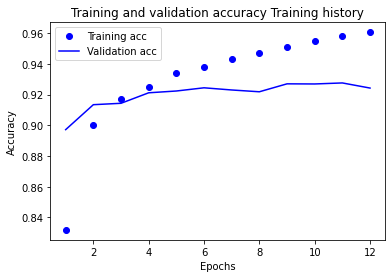

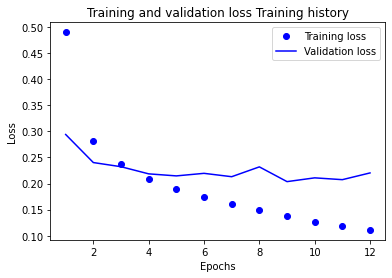

In [ ]:

for history in histories:

  epochrange = range(1, stop_epoch + 1)
  train_acc = history[0].history['accuracy']
  val_acc = history[0].history['val_accuracy']

  train_loss = history[0].history['loss']
  val_loss = history[0].history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc', color=history[2])
  plt.plot(epochrange, val_acc, 'b', label='Validation acc', color=history[2])
  plt.title('Training and validation accuracy '+ history[1])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss', color=history[2])
  plt.plot(epochrange, val_loss, 'b', label='Validation loss',color= history[2])
  plt.title('Training and validation loss ' + history[1])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Här ser vi att lossen kryper stadigt neråt, vilket inte riktigt var fallet med default learning raten, då hoppade den upp och ner lite mer. Accuracyn kryper också sakta uppåt men verkar nå ett sorts tak ganska snabbt.